## Topic Modelling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from gensim import corpora
from gensim import models
from gensim.utils import simple_preprocess
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('fake_or_real_news.csv')
df = df[['text', 'label']]

### Preprocesado

In [3]:
# Eliminar los caracteres especiales
r = re.compile('[^a-zA-Z0-9 ]+')
df['text'] = df['text'].apply(lambda x: r.sub(' ', x))

# Eliminar los espacios en blanco duplicados
r = re.compile('\\s+')
df['text'] = df['text'].apply(lambda x: r.sub(' ', x))

In [4]:
df

,text,label
0,Daniel Greenfield a Shillman Journalism Fellow...,FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U S Secretary of State John F Kerry said Monda...,REAL
3,Kaydee King KaydeeKing November 9 2016 The le...,FAKE
4,It s primary day in New York and front runners...,REAL
...,...,...
6330,The State Department told the Republican Natio...,REAL
6331,The P in PBS Should Stand for Plutocratic or P...,FAKE
6332,Anti Trump Protesters Are Tools of the Oligar...,FAKE
6333,ADDIS ABABA Ethiopia President Obama convened ...,REAL


### LSI Model

In [5]:
texts = df['text'].apply(simple_preprocess)

In [6]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in texts]

In [7]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [8]:
n_topics = 15

# Construir modelo LSI
lsi_model = models.LsiModel(corpus_tfidf,
                            id2word=dictionary,
                            num_topics=n_topics)

In [9]:
lsi_model.print_topics()

[(0,
  '0.284*"trump" + 0.203*"clinton" + 0.121*"sanders" + 0.121*"her" + 0.118*"she" + 0.090*"cruz" + 0.088*"campaign" + 0.087*"hillary" + 0.087*"obama" + 0.083*"party"'),
 (1,
  '-0.412*"dismantling" + -0.318*"obamacare" + -0.278*"killing" + -0.275*"pushing" + -0.270*"tax" + -0.263*"reform" + -0.244*"rules" + -0.228*"list" + -0.208*"administration" + 0.184*"trump"'),
 (2,
  '0.291*"trump" + 0.217*"dismantling" + 0.206*"cruz" + 0.183*"sanders" + 0.158*"obamacare" + 0.141*"pushing" + -0.139*"russia" + 0.138*"reform" + 0.134*"rules" + 0.133*"tax"'),
 (3,
  '-0.392*"clinton" + -0.309*"fbi" + -0.240*"emails" + -0.221*"comey" + -0.218*"her" + 0.184*"cruz" + -0.175*"she" + -0.174*"sanders" + -0.167*"investigation" + -0.161*"hillary"'),
 (4,
  '0.612*"sanders" + -0.384*"trump" + -0.175*"fbi" + 0.158*"iran" + 0.147*"clinton" + -0.144*"comey" + 0.128*"delegates" + 0.118*"bernie" + 0.116*"democratic" + -0.091*"investigation"'),
 (5,
  '0.334*"trump" + 0.275*"russia" + 0.213*"russian" + 0.196*"s

In [10]:
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(lsi_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

topic_words.head()

,value,word,topic
0,0.284344,trump,0
1,0.202661,clinton,0
2,0.121271,sanders,0
3,0.120675,her,0
4,0.117647,she,0


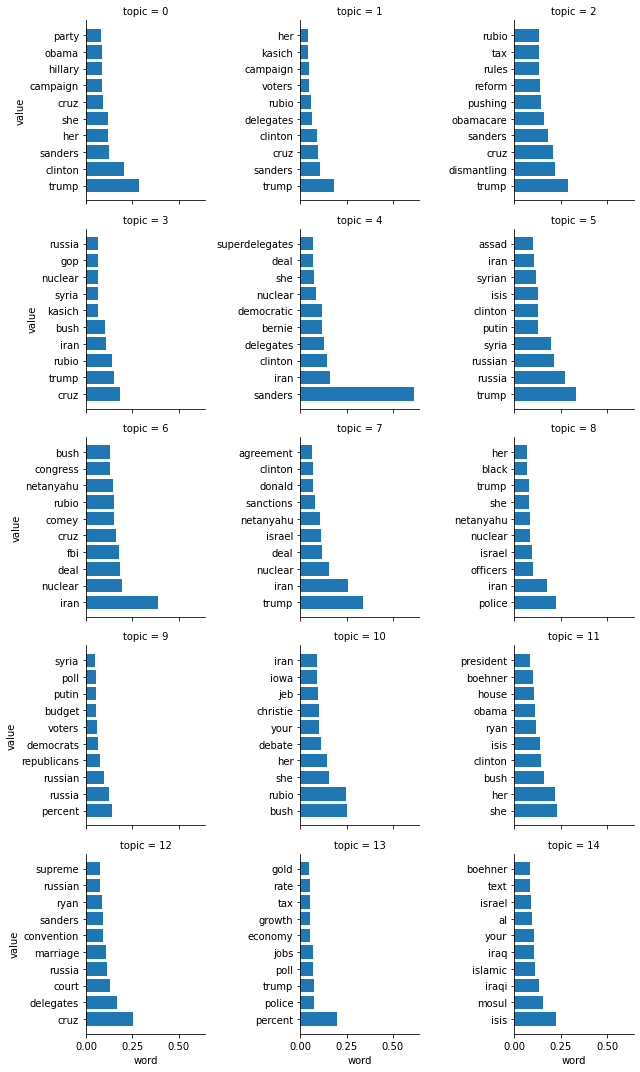

In [11]:
g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value")

### LDA

In [12]:
n_topics = 15

lda_model = models.LdaModel(corpus=corpus, num_topics=n_topics)

In [13]:
lda_model.print_topics()

[(0,
  '0.013*"412" + 0.008*"190" + 0.008*"362" + 0.005*"193" + 0.005*"266" + 0.004*"911" + 0.004*"747" + 0.004*"223" + 0.003*"961" + 0.003*"241"'),
 (1,
  '0.006*"624" + 0.005*"422" + 0.004*"78" + 0.004*"1762" + 0.004*"432" + 0.003*"728" + 0.003*"219" + 0.003*"633" + 0.003*"145" + 0.003*"192"'),
 (2,
  '0.005*"559" + 0.005*"190" + 0.005*"78" + 0.005*"728" + 0.004*"362" + 0.004*"192" + 0.003*"412" + 0.003*"299" + 0.003*"422" + 0.003*"145"'),
 (3,
  '0.004*"219" + 0.004*"682" + 0.004*"972" + 0.004*"624" + 0.003*"2217" + 0.003*"710" + 0.003*"2566" + 0.003*"837" + 0.003*"2568" + 0.003*"422"'),
 (4,
  '0.021*"837" + 0.011*"412" + 0.008*"635" + 0.006*"78" + 0.005*"193" + 0.005*"3846" + 0.004*"13611" + 0.004*"6004" + 0.004*"750" + 0.004*"911"'),
 (5,
  '0.021*"412" + 0.014*"78" + 0.009*"66" + 0.007*"288" + 0.006*"576" + 0.006*"135" + 0.006*"891" + 0.005*"190" + 0.005*"865" + 0.005*"750"'),
 (6,
  '0.025*"412" + 0.010*"78" + 0.007*"192" + 0.004*"135" + 0.004*"914" + 0.004*"422" + 0.004*"299" 

In [14]:
lda_viz = gensimvis.prepare(lda_model, corpus, dictionary)
lda_viz

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/studio-lab

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.109396  0.026589       1        1  13.129976
8      0.027395 -0.027942       2        1  11.103120
12    -0.053555  0.002619       3        1  10.434650
14    -0.032303 -0.023962       4        1   9.002851
9      0.064594  0.009521       5        1   8.002428
6     -0.032210  0.033348       6        1   7.912318
11     0.130217  0.092934       7        1   7.836390
3      0.076930 -0.046971       8        1   7.144298
10     0.003143  0.016817       9        1   6.544548
0     -0.064072  0.021063      10        1   6.194927
13     0.032591 -0.110400      11        1   3.471647
1      0.039064  0.031004      12        1   3.414654
2     -0.012162 -0.018362      13        1   2.568933
7     -0.008960 -0.036544      14        1   2.125019
4     -0.061277  0.030286      15        1   1.114241, topic_info=          Term          Freq         Total Category  logprob  loglift
412      trump  22367.000000  22367.000000  Default  30.0000  30.0000
78     clinton  17407.000000  17407.000000  Default  29.0000  29.0000
837    percent   4591.000000   4591.000000  Default  28.0000  28.0000
190        her  10956.000000  10956.000000  Default  27.0000  27.0000
362        she  11014.000000  11014.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
972       year     81.238757   5779.367354  Topic15  -5.9590   0.2323
443      while     78.351319   4822.181748  Topic15  -5.9952   0.3772
968      white     75.755102   4743.081978  Topic15  -6.0289   0.3601
559  president     76.472394   8499.671453  Topic15  -6.0195  -0.2139
97       could     75.136865   6268.143235  Topic15  -6.0371   0.0731

[1310 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
8725       1  0.012910  abdeslam
8725       2  0.025821  abdeslam
8725       5  0.012910  abdeslam
8725       7  0.916645  abdeslam
0          1  0.011791    abedin
...      ...       ...       ...
14602      6  0.004766      zika
14602      8  0.943694      zika
14602     11  0.004766      zika
14602     12  0.004766      zika
14602     14  0.004766      zika

[8060 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 13, 15, 10, 7, 12, 4, 11, 1, 14, 2, 3, 8, 5])